# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado


# 1) Libraries

In [2]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold  # Hyperparameter tuning and cross-validation
from sklearn.tree import DecisionTreeClassifier  # DecisionTreeClassifier for tree-based models
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier for ensemble learning
from sklearn.metrics import confusion_matrix, accuracy_score  # Metrics for model evaluation
from sklearn.svm import SVC          # Support Vector Classification
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
import xgboost as xgb               # XGBoost for gradient boosting
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes classifier
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.model_selection import train_test_split  # Splitting data for training and testing
from xgboost import plot_tree       # Plotting decision trees in XGBoost
from sklearn.model_selection import cross_val_score  # Cross-validation for model evaluation
from sklearn.model_selection import KFold  # K-Fold cross-validation

# Image Processing and Feature Extraction
from skimage.feature import graycomatrix, graycoprops  # Image texture features using co-occurrence matrix
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy


2023-11-21 11:07:52.602891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Texture feature extraction

In [3]:
def texture_feature_calculation(imagen_float: np.ndarray) -> list:
    """
    Calculates texture features from a given floating-point image.

    Parameters:
    - imagen_float (numpy.ndarray): Input image as a NumPy array with floating-point values.

    Returns:
    - features (list): List containing the calculated texture features.

    Note:
    - This function assumes that 'imagen_float' is in the range [0.0, 1.0].
    - The input image is first scaled to the range [0, 255] and then converted to uint8.
    - Texture features are computed using gray-level co-occurrence matrix (GLCM).

    References:
    - graycomatrix: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.greycomatrix
    - greycoprops: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.greycoprops
    """

    # Scale the input image to the range [0, 255]
    imagen_float = imagen_float * 255.0

    # Convert the image to uint8
    image: np.ndarray = imagen_float.astype(np.uint8)

    # Compute gray-level co-occurrence matrix (GLCM)
    gray_matrix = graycomatrix(image, [1], [0], levels=256)[1:, 1:, :, :]

    # Calculate texture features using GLCM properties
    diss: float = graycoprops(gray_matrix, 'dissimilarity')[0][0]
    cont: float = graycoprops(gray_matrix, 'contrast')[0][0]
    hom: float = graycoprops(gray_matrix, 'homogeneity')[0][0]
    en: float = graycoprops(gray_matrix, 'energy')[0][0]
    corr: float = graycoprops(gray_matrix, 'correlation')[0][0]
    ASM: float = graycoprops(gray_matrix, 'ASM')[0][0]

    # Calculate mean and standard deviation of the image
    mean: float = np.mean(image[image != 0])
    std: float = np.sqrt(np.sum((image - mean) ** 2) / (image.size - 1))

    # Create a binary image representing regions around the mean intensity
    lumen_image = np.zeros_like(image)
    lumen_image[(image >= int(mean) - 10) | (image >= int(mean) + 10)] = 1

    # Calculate the proportion of lumen pixels in the image
    lumen: float = lumen_image[lumen_image > 0].sum() / (image.size - 1)

    # Aggregate all calculated features into a list
    features: list = [diss, cont, hom, en, corr, ASM, mean, std, lumen]

    return features


## Geometric feature extraction

In [4]:
import numpy as np
import skimage.measure

def calculate_binary_volume(binary_image: np.ndarray) -> int:
    """
    Calculates the volume of a binary image.

    Parameters:
    - binary_image (numpy.ndarray): Input binary image represented as a NumPy array.

    Returns:
    - volume (int): Volume of the binary image.
    """
    # Convert the binary image to uint8
    binary_image = binary_image.astype(np.uint8)
    
    # Calculate the volume by summing all non-zero pixels in the binary image
    volume: int = np.sum(binary_image)
    return volume

def calculate_binary_perimeter(binary_image: np.ndarray) -> float:
    """
    Calculates the perimeter of a binary image.

    Parameters:
    - binary_image (numpy.ndarray): Input binary image represented as a NumPy array.

    Returns:
    - perimeter (float): Perimeter of the binary image.
    """
    # Calculate the perimeter using the skimage.measure.perimeter function
    perimeter: float = skimage.measure.perimeter(binary_image)
    return perimeter

def basic_geometric_feature_extraction(binary_image: np.ndarray) -> tuple:
    """
    Performs basic geometric feature extraction on a binary image.

    Parameters:
    - binary_image (numpy.ndarray): Input binary image represented as a NumPy array.

    Returns:
    - features (tuple): Tuple containing the calculated volume, perimeter, ratio, and inverse ratio.
    """
    # Calculate the binary volume and perimeter using the previously defined functions
    volume: int = calculate_binary_volume(binary_image)
    perimeter: float = calculate_binary_perimeter(binary_image)

    # Calculate the ratio and inverse ratio, handling cases where volume or perimeter is zero
    if volume != 0 and perimeter != 0:
        ratio: float = volume / perimeter
        inverse_ratio: float = perimeter / volume
    else:
        ratio: float = 0
        inverse_ratio: float = 0

    # Return the calculated features as a tuple
    return volume, perimeter, ratio, inverse_ratio
import numpy as np
from typing import List, Tuple

def radios_y_cocientes_relevantes(volumenes: List[float], perimetros: List[float]) -> Tuple[float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float]:
    """
    Calculates various ratios and relevant radii based on given volumes and perimeters.

    Parameters:
    - volumenes (List[float]): List containing volumes of different structures.
    - perimetros (List[float]): List containing perimeters of different structures.

    Returns:
    - ratios and radii (Tuple[float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float]): Tuple containing various ratios and relevant radii.
    """
    # Calculating various ratios based on given volumes
    ratioA = volumenes[0] / volumenes[1] if volumenes[1] != 0 else 1  # Volume ICM / Volume ZP
    ratioB = volumenes[0] / volumenes[2] if volumenes[2] != 0 else 1  # Volume ICM / Volume TE
    ratioC = volumenes[1] / volumenes[2] if volumenes[2] != 0 else 1  # Volume ZP / Volume TE
    ratio1 = volumenes[0] / volumenes[6] if volumenes[6] != 0 else 1  # Volume ICM / Volume embryo
    ratio2 = volumenes[0] / volumenes[7] if volumenes[7] != 0 else 1  # Volume ICM / Volume inner embryo
    ratio3 = volumenes[0] / volumenes[10] if volumenes[10] != 0 else 1  # Volume ICM / Volume blastocoel
    ratio4 = volumenes[1] / volumenes[6] if volumenes[6] != 0 else 1  # Volume ZP / Volume embryo
    ratio5 = volumenes[1] / volumenes[7] if volumenes[7] != 0 else 1  # Volume ZP / Volume inner embryo
    ratio6 = volumenes[1] / volumenes[10] if volumenes[10] != 0 else 1  # Volume ZP / Volume blastocoel
    ratio7 = volumenes[2] / volumenes[6] if volumenes[6] != 0 else 1  # Volume TE / Volume inner embryo

    # Calculating various ratios based on given perimeters
    ratio_per1 = perimetros[0] / perimetros[6] if perimetros[6] != 0 else 1  # Perimeter ICM / Perimeter embryo
    ratio_per2 = perimetros[0] / perimetros[7] if perimetros[7] != 0 else 1  # Perimeter ICM / Perimeter inner embryo
    ratio_per3 = perimetros[0] / perimetros[10] if perimetros[10] != 0 else 1  # Perimeter ICM / Perimeter blastocoel
    
    # Calculating relevant radii based on given volumes
    radius1 = np.sqrt(volumenes[6]) if volumenes[6] >= 0 else 1  # Equivalent to embryo radius
    radius2 = np.sqrt(volumenes[7]) if volumenes[7] >= 0 else 1  # Equivalent to inner embryo's radius

    # Calculating the reciprocal of each ratio
    reciprocal_ratioA = 1 / ratioA
    reciprocal_ratioB = 1 / ratioB
    reciprocal_ratioC = 1 / ratioC
    reciprocal_ratio1 = 1 / ratio1
    reciprocal_ratio2 = 1 / ratio2
    reciprocal_ratio3 = 1 / ratio3
    reciprocal_ratio4 = 1 / ratio4
    reciprocal_ratio5 = 1 / ratio5
    reciprocal_ratio6 = 1 / ratio6
    reciprocal_ratio7 = 1 / ratio7
    reciprocal_ratio_per1 = 1 / ratio_per1
    reciprocal_ratio_per2 = 1 / ratio_per2
    reciprocal_ratio_per3 = 1 / ratio_per3

    return (
        ratioA, ratioB, ratioC, radius1, radius2,
        ratio1, ratio2, ratio3, ratio4, ratio5, ratio6, ratio7,
        ratio_per1, ratio_per2, ratio_per3,
        reciprocal_ratioA, reciprocal_ratioB, reciprocal_ratioC,
        reciprocal_ratio1, reciprocal_ratio2, reciprocal_ratio3,
        reciprocal_ratio4, reciprocal_ratio5, reciprocal_ratio6,
        reciprocal_ratio7, reciprocal_ratio_per1, reciprocal_ratio_per2, reciprocal_ratio_per3)

def invertir_unos_y_ceros(array: List[List[int]]) -> List[List[int]]:
    """
    Inverts ones and zeros in a 2D array.

    Parameters:
    - array (List[List[int]]): Input 2D array.

    Returns:
    - resultado (List[List[int]]): 2D array with inverted ones and zeros.
    """
    # Creating a deep copy of the input array
    resultado = [fila[:] for fila in array]

    # Inverting ones and zeros in the array
    for i in range(len(resultado)):
        for j in range(len(resultado[i])):
            if resultado[i][j] == 1:
                resultado[i][j] = 0
            else:
                resultado[i][j] = 1

    return resultado

def signal_phased(signal: np.ndarray, thickness_signal: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Phases a signal based on the minimum value.

    Parameters:
    - signal (numpy.ndarray): Input signal.
    - thickness_signal (numpy.ndarray): Thickness signal.

    Returns:
    - signal_out (numpy.ndarray): Phased signal.
    - signal_thickness_out (numpy.ndarray): Phased thickness signal.
    """
    # Find the index of the minimum value in the signal
    m = np.argmin(signal)

    # Concatenate the signal based on the minimum value index to phase it
    signal_out = np.concatenate((signal[m:], signal[:m]))
    thickness_signal_out = np.concatenate((thickness_signal[m:], thickness_signal[:m]))

    return signal_out, thickness_signal_out



## Topographic functions

In [5]:
import numpy as np
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
from typing import Tuple, Union

def cells_statistics_extractor(
    signal: np.ndarray,
    signal_thickness: np.ndarray,
    vis_cell_divisions: bool,
    *kwargs: Union[int, float]
) -> Tuple[int, float, float]:
    """
    Extracts statistics from a signal representing cell data.

    Parameters:
    - signal (numpy.ndarray): Input signal representing cell data.
    - signal_thickness (numpy.ndarray): Signal representing thickness of cells.
    - vis_cell_divisions (bool): Flag to visualize cell divisions.
    - *kwargs: Variable arguments for fine-tuning the signal processing and peak detection.
        - kwargs[0] (int): Window length for Savitzky-Golay filter.
        - kwargs[1] (int): Polynomial order for Savitzky-Golay filter.
        - kwargs[2] (int): Minimum distance between peaks.
        - kwargs[3] (float): Minimum peak prominence.
        - kwargs[4] (float): Minimum peak height.

    Returns:
    - Tuple[int, float, float]: Number of cells, mean thickness, and standard deviation of thickness.
    """
    # Extract parameters from variable arguments
    kwargs = kwargs[0]

    # Smooth the input signal using a Savitzky-Golay filter
    signal = savgol_filter(signal, window_length=kwargs[0], polyorder=kwargs[1])

    # Find peaks in the signal to detect cell locations
    peaks, _ = find_peaks(signal, height=kwargs[4], distance=kwargs[2], prominence=kwargs[3])

    # Calculate the number of cells from the detected peaks
    n_cells = len(peaks)

    # Calculate mean and standard deviation of cell thickness
    mean_thickness = np.mean(signal_thickness)
    std_thickness = np.std(signal_thickness)

    # Visualize cell divisions if required
    if vis_cell_divisions:
        plt.plot(peaks, signal[peaks], 'ro')

    return n_cells, mean_thickness, std_thickness


def cell_select(
    signal: np.ndarray,
    signal_thickness: np.ndarray,
    vis_cell_divisions: bool,
    *kwargs: Union[int, float]
) -> List[np.ndarray]:
    """
    Selects cells based on signal characteristics.

    Parameters:
    - signal (numpy.ndarray): Input signal representing cell data.
    - signal_thickness (numpy.ndarray): Signal representing thickness of cells.
    - vis_cell_divisions (bool): Flag to visualize cell divisions.
    - *kwargs: Variable arguments for fine-tuning the signal processing and peak detection.
        - kwargs[0] (int): Window length for Savitzky-Golay filter.
        - kwargs[1] (int): Polynomial order for Savitzky-Golay filter.
        - kwargs[2] (int): Minimum distance between valleys.
        - kwargs[3] (float): Minimum valley prominence.
        - kwargs[4] (float): Minimum valley height.

    Returns:
    - List[np.ndarray]: List of selected cells represented by thickness signals.
    """
    # Extract parameters from variable arguments
    kwargs = kwargs[0]

    # Smooth the input signal using a Savitzky-Golay filter
    signal = savgol_filter(signal, window_length=kwargs[0], polyorder=kwargs[1])

    # Find valleys in the inverted signal to detect cell divisions
    valleys, _ = find_peaks(1 - signal, height=kwargs[4], distance=kwargs[2], prominence=kwargs[3])

    # Ensure valleys include the start and end points
    valleys = np.hstack((valleys, len(signal) - 1))
    valleys = np.hstack((0, valleys))

    # Initialize a list to store individual cells
    cells = []

    # Iterate through each valley to extract individual cells
    for k, i in enumerate(valleys[:-1]):
        if i != valleys[-1]:
            # If not the last valley, extract the thickness signal between current and next valley
            out = signal_thickness[i:valleys[k + 1]]
        if i == valleys[-1]:
            # If the last valley, wrap around to the beginning to extract the thickness signal
            out = np.hstack((signal_thickness[i:], signal_thickness[:valleys[0]]))
        cells.append(out)

    # Visualize cell divisions if required
    if vis_cell_divisions:
        plt.plot(signal)
        plt.plot(valleys, signal[valleys], 'bo')
        plt.show()

    return cells



def individual_cell_feature_extractor(cells: List[np.ndarray], vis: bool = False) -> List[float]:
    """
    Extracts individual cell features from a list of cell signals.

    Parameters:
    - cells (List[np.ndarray]): List of signals representing individual cells.
    - vis (bool): Flag to visualize cell features. Default is False.

    Returns:
    - List[float]: List of extracted features, including statistics on parabolic coefficients,
      cell heights, cell lengths, and total cell lengths.
    """
    # Initialize lists to store features
    parabolic_coef = []
    cell_height = []
    cell_length = []
    cell_total_length = []

    # Iterate through each cell signal
    for cell in cells:
        # Fit a parabolic curve to the cell signal
        x = np.arange(len(cell))
        a = np.polyfit(x, cell, 2)
        pfit = a[0] * x**2 + a[1] * x + a[2]

        # If the parabolic coefficient is negative, consider it valid
        if a[0] < 0:
            # Visualize the cell signal and the fitted parabolic curve if required
            if vis:
                plt.plot(cell)
                plt.plot(x, pfit)
                plt.show()

            # Extract features from the parabolic curve and cell signal
            parabolic_coef.append(a[0])
            cell_height.append(np.max(cell))
            cell_length.append(len(cell))
            argmax_pfit = np.argmax(pfit)
            cell_total_length.append(2 * max(argmax_pfit, len(cell) - argmax_pfit))

    # Helper function to calculate statistics from a list of data
    def calculate_stats(data: List[Union[int, float]]) -> List[float]:
        mean = np.mean(data)
        std = np.std(data)
        maximum = np.max(data)
        minimum = np.min(data)
        return [mean, std, maximum, minimum]

    # Calculate statistics for each feature
    par_coef = calculate_stats(parabolic_coef)
    cell_h = calculate_stats(cell_height)
    cell_l = calculate_stats(cell_length)
    cell_total = calculate_stats(cell_total_length)

    # Combine individual statistics into a single list of features
    return par_coef + cell_h + cell_l + cell_total



def extract_topographic_features(
    img: np.ndarray,
    arguments: List[Union[int, float]],
    vis_arguments: List[Union[bool, int, float]],
    is_ICM: bool = False,
    is_ZP: bool = False,
    is_TE: bool = False
) -> List[Union[int, float]]:
    """
    Extracts topographic features from an image.

    Parameters:
    - img (numpy.ndarray): Input image.
    - arguments (List[Union[int, float]]): List of arguments for processing.
    - vis_arguments (List[Union[bool, int, float]]): List of arguments for visualization.
    - is_ICM (bool): Flag indicating if the image represents Inner Cell Mass (ICM). Default is False.
    - is_ZP (bool): Flag indicating if the image represents Zona Pellucida (ZP). Default is False.
    - is_TE (bool): Flag indicating if the image represents Trophectoderm (TE). Default is False.

    Returns:
    - List[Union[int, float]]: Extracted topographic features.
    """
    # Unwrap the image to get signals
    if is_ICM:
        signal, _, signal_thickness, _ = unwrapper(img, vis_arguments[0], is_ICM)
    elif is_ZP or is_TE:
        signal, _, signal_thickness, _ = unwrapper(img, vis_arguments[0])

    # Apply Savitzky-Golay filter to smooth signals
    signal = savgol_filter(signal, window_length=10, polyorder=2)
    signal_thickness = savgol_filter(signal_thickness, window_length=10, polyorder=2)

    # Phase-align the signals
    signal, signal_thickness = signal_phased(signal, signal_thickness)

    # Extract statistics from the signals
    n_cells, mean_cells, std_cells = cells_statistics_extractor(signal, signal_thickness, vis_arguments[2], arguments)

    if is_ZP:
        # If ZP, only include mean and std of the signals
        total_features = [mean_cells, std_cells]
    else:
        # If not ZP, extract individual cell features
        cells = cell_select(signal, signal_thickness, vis_arguments[2], arguments)
        cell_features = individual_cell_feature_extractor(cells, vis_arguments[1])
        # Combine individual cell features with overall statistics
        total_features = cell_features + [n_cells, mean_cells, std_cells]

    return total_features


def unwrapper(
    img: np.ndarray,
    visualize: bool,
    is_ICM: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Unwraps an image into polar coordinates and extracts relevant features.

    Parameters:
    - img (numpy.ndarray): Input image.
    - visualize (bool): Flag to visualize the unwrapping process.
    - is_ICM (bool): Flag indicating if the image represents Inner Cell Mass (ICM). Default is False.

    Returns:
    - Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        - peak (numpy.ndarray): Array representing peak values.
        - valley (numpy.ndarray): Array representing valley values.
        - TeThickness (numpy.ndarray): Array representing Thickness of Trophectoderm.
        - polar (numpy.ndarray): Polar representation of the image.
    """
    def get_polar_image(img: np.ndarray, radius: int, center: List[int], nsamples: int) -> np.ndarray:
        """
        Convert the image to polar coordinates.

        Parameters:
        - img (numpy.ndarray): Input image.
        - radius (int): Radius of the polar coordinate system.
        - center (List[int]): Center coordinates of the image.
        - nsamples (int): Number of samples in the polar coordinate system.

        Returns:
        - polar (numpy.ndarray): Polar representation of the image.
        """
        samples = np.linspace(0, 2 * np.pi, nsamples)[:-1]
        polar = np.zeros((radius, nsamples))
        for r in range(radius):
            for theta in samples:
                x = int(r * np.cos(theta) + center[0])
                y = int(r * np.sin(theta) + center[1])
                polar[int(r)][int(theta * nsamples / 2.0 / np.pi)] = img[y][x]
        return polar

    def invertir_unos_y_ceros(arr: np.ndarray) -> np.ndarray:
        """
        Invert ones and zeros in the array.

        Parameters:
        - arr (numpy.ndarray): Input array.

        Returns:
        - inverted_arr (numpy.ndarray): Inverted array.
        """
        return np.logical_not(arr).astype(int)

    radius = int(np.min(img.shape) / 2)
    center = [int(np.min(img.shape) / 2), int(np.min(img.shape[0]) / 2)]
    nsamples = 360

    # Convert the image to polar coordinates
    polar = get_polar_image(img, radius, center, nsamples)

    # Invert ones and zeros if it is ICM
    if is_ICM:
        polar = invertir_unos_y_ceros(polar)

    peak = np.zeros(359)
    valley = np.zeros(359)

    for i in range(359):
        non_zero_indices = np.where(polar[:, i] > 0)[0]
        if len(non_zero_indices) == 0:
            peak[i] = 0
            valley[i] = 0
        else:
            peak[i] = radius - non_zero_indices[0]
            valley[i] = radius - non_zero_indices[-1]

    peak = peak / radius
    valley = valley / radius
    TeThickness = peak - valley

    # Visualize the polar image and TeThickness if required
    if visualize:
        plt.imshow(polar)
        plt.show()
        plt.plot(TeThickness)
        plt.show()

    return peak, valley, TeThickness, polar


## Funciones de imágenes

In [6]:
import numpy as np
from scipy import ndimage

def segmentate_images(image: np.ndarray, label: np.ndarray, vis: bool = False) -> np.ndarray:
    """
    Segments an image based on a given label.

    Parameters:
    - image (np.ndarray): Input image.
    - label (np.ndarray): Label used for segmentation.
    - vis (bool): Flag for visualization. Default is False.

    Returns:
    - masked_image (np.ndarray): Masked image after segmentation.
    """
    # Element-wise multiplication of the image and label to segment it
    masked_image = image * label
    
    return masked_image

def mix_labels(images: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Combines and fills binary images based on specific rules.

    Parameters:
    - images (List[np.ndarray]): List of binary images.

    Returns:
    - Tuple containing different versions of the binary images after combining and filling.
      - images: Original binary images.
      - sum_images: Combination of images by summing them.
      - filled_images_2: Binary images filled based on specific rules.
      - filled_images_3: Binary images filled based on specific rules.
    """
    # Combination of images by summing them
    sum_images = [
        np.where((images[1] + images[0]) != 0, 1, 0),
        np.where((images[2] + images[0]) != 0, 1, 0),
        np.where((images[2] + images[1]) != 0, 1, 0)
    ]

    # Binary images filled based on specific rules
    filled_images_2 = [
        ndimage.binary_fill_holes(np.where((images[1]) != 0, 1, 0)),
        ndimage.binary_fill_holes(sum_images[0]) - images[1],
        np.where(ndimage.binary_fill_holes(images[2]) - images[0] != 0, 1, 0)
    ]

    # Binary images filled based on specific rules
    filled_images_3 = [
        np.where(ndimage.binary_fill_holes(sum_images[0]) - images[2] != 0, 1, 0),
        ndimage.binary_fill_holes(np.where((images[2]) != 0, 1, 0)) - images[2],
        np.where(ndimage.binary_fill_holes(images[2]) - images[2] - images[0] != 0, 1, 0)
    ]

    return images, sum_images, filled_images_2, filled_images_3


def crop_binary_image(binary_image: np.ndarray, vis: bool = False) -> np.ndarray:
    """
    Crops a binary image to remove excess background.

    Parameters:
    - binary_image (np.ndarray): Input binary image.
    - vis (bool): Flag for visualization. Default is False.

    Returns:
    - cropped_label (np.ndarray): Cropped binary image.
    """
    if not np.any(binary_image):
        return None

    # Find non-zero indices in the binary image
    non_zero_indices = np.argwhere(binary_image)
    min_x, min_y = non_zero_indices.min(axis=0)
    max_x, max_y = non_zero_indices.max(axis=0)

    # Crop the binary image based on non-zero indices
    cropped_label = binary_image[min_x:max_x + 1, min_y:max_y + 1]
    cropped_label = cropped_label.astype(int)

    if vis:
        plt.imshow(cropped_label)
        plt.show()

    # Pad the cropped image
    cropped_label = padder(cropped_label)
    return cropped_label

def padder(img: np.ndarray) -> np.ndarray:
    """
    Pads and adjusts the size of the input image.

    Parameters:
    - img (np.ndarray): Input image.

    Returns:
    - output_img (np.ndarray): Padded and adjusted image.
    """
    auxiliar_pad = 5
    img = np.pad(img, auxiliar_pad)

    # Get the limits of the non-zero values in the padded image
    x_lim = (np.min(np.where(img > 0.5)[0]), np.max(np.max(np.where(img > 0.5)[0])))
    y_lim = (np.min(np.where(img > 0.5)[1]), np.max(np.max(np.where(img > 0.5)[1])))

    # Crop the padded image based on non-zero limits
    img_crop = img[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]

    # Adjust the size of the cropped image
    if img_crop.shape[0] < img_crop.shape[1]:
        ceros = np.zeros((int((img_crop.shape[1] - img_crop.shape[0]) / 2), img_crop.shape[1]))
        output_img = np.vstack((ceros, img_crop))
        output_img = np.vstack((output_img, ceros))
    elif img_crop.shape[0] > img_crop.shape[1]:
        ceros = np.zeros((img_crop.shape[0], int((img_crop.shape[0] - img_crop.shape[1]) / 2)))
        output_img = np.hstack((ceros, img_crop))
        output_img = np.hstack((output_img, ceros))
    else:
        output_img = img_crop

    return output_img

def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region

def plot_images(imgs: List[np.ndarray], titles: bool = False) -> None:
    """
    Plots a list of images.

    Parameters:
    - imgs (List[np.ndarray]): List of images to plot.
    - titles (bool): Flag for displaying titles. Default is False.
    """
    num_images = len(imgs)
    fig, axs = plt.subplots(1, num_images, figsize=(2 * num_images, 2))

    for i in np.arange(num_images):
        axs[i].imshow(imgs[i], cmap='gray')
        if titles:
            axs[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()


def multi_layered_segmentation(images, blast):
    """
    Performs multi-layered segmentation of images based on different label combinations.

    Parameters:
    - images (list): List of images representing different structures.
    - blast (numpy.ndarray): Image representing blastocyst.

    Returns:
    - all_labels (list): List of labeled structures for each combination.
    - all_masked_images (list): List of masked images for each combination.
    """
    # Mix different labels
    images, sum_images, filled_images_2, filled_images_3 = mix_labels(images)

    # Segmentate blastocyst with each label combination
    masked_images = segmentate_images(blast, images)
    masked_sum_images = segmentate_images(blast, sum_images)
    masked_filled_images_2 = segmentate_images(blast, filled_images_2)
    masked_filled_images_3 = segmentate_images(blast, filled_images_3)

    # Group all labels and masked images
    all_labels = [images, sum_images, filled_images_2, filled_images_3]
    all_masked_images = [masked_images, masked_sum_images, masked_filled_images_2, masked_filled_images_3]

    return all_labels, all_masked_images


## Feature extraction functions

In [7]:
def geometric_feature_extraction(all_labels):
    """
    Extracts geometric features from labeled structures.

    Parameters:
    - all_labels (list): List of labeled structures.

    Returns:
    - all_geometric_features (list): List of geometric features for each structure.
    - independent_features (list): List of independent geometric features.
    """
    all_volumes = []
    all_perimeters = []
    all_ratios = []
    all_soitar = []

    # Extract geometric features for each labeled structure
    for group in all_labels:
        for label in group:
            set_of_geometric_features = basic_geometric_feature_extraction(label)
            all_volumes.append(set_of_geometric_features[0])
            all_perimeters.append(set_of_geometric_features[1])
            all_ratios.append(set_of_geometric_features[2])
            all_soitar.append(set_of_geometric_features[3])

    # Calculate relevant ratios
    valores_relevantes = radios_y_cocientes_relevantes(all_volumes, all_perimeters)

    # Group all geometric features
    all_geometric_features = [all_volumes] + [all_perimeters] + [all_ratios] + [all_soitar] + [valores_relevantes]
    independent_features = all_volumes[:3] + all_perimeters[:3] + all_ratios[:3] + all_soitar[:3]

    return all_geometric_features, independent_features

def textural_feature_extraction(all_masked_images):
    """
    Extracts textural features from a list of masked images.

    Parameters:
    - all_masked_images (list): List of masked images.

    Returns:
    - all_texture_features (list): List of textural features for each masked image.
    """
    all_texture_features = []

    # Calculate textural features for each masked image
    for image in all_masked_images[0]:
        textural_features = texture_feature_calculation(image)
        all_texture_features.append(textural_features)

    return all_texture_features

def extract_all_topographic_features(images, arguments_zones, vis_arguments):
    """
    Extracts topographic features from different structures within images.

    Parameters:
    - images (list): List of images representing different structures.
    - arguments_zones (list): List of arguments for processing each structure.
    - vis_arguments (list): List of arguments for visualization.

    Returns:
    - all_topographic_features (list): List of topographic features for each structure.
    """
    # Crop binary images for each structure
    img_TE = crop_binary_image(images[2])
    img_ZP = crop_binary_image(images[1])
    img_ICM = crop_binary_image(images[0])

    # Assign arguments for each structure
    arguments_TE = arguments_zones[2]
    arguments_ZP = arguments_zones[1]
    arguments_ICM = arguments_zones[0]

    # Extract topographic features for each structure
    features_trophectoderm = extract_topographic_features(img_TE, arguments_TE, vis_arguments, is_TE=True)
    features_intercellular = extract_topographic_features(img_ICM, arguments_ICM, vis_arguments, is_ICM=True)
    features_pellucid = extract_topographic_features(img_ZP, arguments_ZP, vis_arguments, is_ZP=True)

    # Group all topographic features
    all_topographic_features = [features_intercellular] + [features_trophectoderm]  + [features_pellucid]

    return all_topographic_features

def mix_features(textural_features, geometric_features, topographic_features):
    """
    Mixes different types of features into a single feature vector.

    Parameters:
    - textural_features (list): List of textural features.
    - geometric_features (list): List of geometric features.
    - topographic_features (list): List of topographic features.

    Returns:
    - features (list): Mixed feature vector.
    """
    # Combine different feature types
    all_mixed_features = textural_features + geometric_features + topographic_features
    
    # Flatten the nested list into a single list
    features = []
    [features.extend(sublist) for sublist in all_mixed_features]
    
    # Convert features to integers
    features = [int(x) for x in features]
    
    return features

def feature_extraction_full_dataset(arguments_zones, vis_arguments):
    """
    Extracts features from a full dataset of images.

    Parameters:
    - arguments_zones (list): List of arguments for processing each structure.
    - vis_arguments (list): List of arguments for visualization.

    Returns:
    - all_features (list): List of feature vectors for each image in the dataset.
    """
    n_data = 250

    all_features = []

    # Loop through each image in the dataset
    for index in tqdm(range(1, n_data)):
        img_ICM = load_image('data/BlastsOnline//GT_ICM', index)
        img_TE = load_image('data/BlastsOnline/GT_TE', index)
        img_ZP = load_image('data/BlastsOnline/GT_ZP', index)
        img_Blast = load_image('data/BlastsOnline/Images', index)

        images = [img_ICM, img_ZP, img_TE]

        # Segment images into different layers
        all_labels, all_masked_images = multi_layered_segmentation(images, img_Blast)

        # Extract geometric features
        geometric_features, independent_geometric_features = geometric_feature_extraction(all_labels)  # 4 x 3

        # Extract textural features
        textural_features = textural_feature_extraction(all_masked_images)

        # Extract topographic features
        topographic_features = extract_all_topographic_features(images, arguments_zones, vis_arguments)

        # Mix different features into a single vector
        features = mix_features(textural_features, geometric_features, topographic_features)

        # Append the feature vector to the list
        all_features.append(features)

    # Save features to a JSON file
    with open('data/segmented_features/features.json', 'w') as archivo:
        json.dump(all_features, archivo)

    return all_features

def convert(x):
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2


## Training functions

In [8]:
def apply_PCA(X, n_components):
    """
    Applies Principal Component Analysis (PCA) to the input data.

    Parameters:
    - X (array-like): Input data.
    - n_components (int): Number of components to keep.

    Returns:
    - X_pca (array-like): Transformed data after PCA.
    """
    # Apply PCA to the training set
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the plot of cumulative variance
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.show()
    
    return X_pca


def run_halving_grid_search(X, y, clf, param_grid, scoring='accuracy', cv_splits=5, random_state=42, factor=3):
    """
    Runs a halving grid search for hyperparameter tuning.

    Parameters:
    - X (array-like): Input features.
    - y (array-like): Target variable.
    - clf: Classifier or regressor object.
    - param_grid (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter settings to try.
    - scoring (str): Scoring metric for cross-validation (default is 'accuracy').
    - cv_splits (int): Number of cross-validation splits (default is 5).
    - random_state (int): Random seed for reproducibility (default is 42).
    - factor (int): Reduction factor for each iteration of halving (default is 3).

    Returns:
    - y_pred (array-like): Predicted labels.
    - accuracy (float): Mean accuracy across cross-validation folds.
    - std_dev (float): Standard deviation of accuracy across cross-validation folds.
    """
    # Create the StratifiedKFold object for stratified data splitting
    stratified_kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create the HalvingGridSearchCV object
    halving_grid_search = HalvingGridSearchCV(clf, param_grid, scoring=scoring, cv=stratified_kf, factor=factor)

    # Perform grid search with cross-validation
    tqdm(halving_grid_search.fit(X, y))

    # Get the best model from the grid search
    best_clf = halving_grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", halving_grid_search.best_params_)

    # Get cross-validation results
    cv_results = halving_grid_search.cv_results_

    # Print the mean value and standard deviation
    accuracy = np.mean(cv_results["mean_test_score"])
    std_dev = np.std(cv_results["mean_test_score"])
    print("\nMean Accuracy in cross-validation:", accuracy)
    print("Standard Deviation of Accuracy in cross-validation:", std_dev)

    # Predict labels on the full dataset (last iteration)
    y_pred = best_clf.predict(X)

    return y_pred, accuracy, std_dev


## Naming function

In [9]:
def generate_names():
    """
    Generates names of the features.

    Returns:
    - array with all names.
    """

    textural_names = ['dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std', 'lumen']

    geometric_names = [
        "volume ICM / Volume ZP",
        "volume ICM / Volume TE",
        "volume ZP / Volume TE",
        "equivalent to embryo radius",
        "equivalent to inner embryo's radius",
        "volume ICM / Volume embryo",
        "volume ICM / Volume inner embryo",
        "volume ICM / Volume blastocoel",
        "volume ZP / Volume embryo",
        "volume ZP / Volume inner embryo",
        "volume ZP / Volume blastocoel",
        "volume TE / Volume inner embryo",
        "perimeter ICM / Perimeter embryo",
        "perimeter ICM / Perimeter inner embryo",
        "perimeter ICM / Perimeter blastocoel"
    ]

    inverse_geometric_names = [
        "volume ZP / Volume ICM",
        "volume TE / Volume ICM",
        "volume TE / Volume ZP",
        "volume embryo / Volume ICM",
        "volume inner embryo / Volume ICM",
        "volume blastocoel / Volume ICM",
        "volume embryo / Volume ZP",
        "volume inner embryo / Volume ZP",
        "volume blastocoel / Volume ZP",
        "volume inner embryo / Volume TE",
        "perimeter embryo / Perimeter ICM",
        "perimeter inner embryo / Perimeter ICM",
        "perimeter blastocoel / Perimeter ICM"
    ]

    topographic_parabolic_names = ["par_coef_mean", "par_coef_std" , "par_coef_maximum", 'par_coef_minimum']
    cell_height_names = ["cell_height_mean", "cell_height_std" , "cell_height_maximum", 'cell_height_minimum']
    cell_relative_length_names = ["cell_relative_length_mean", "cell_relative_length_std" , "cell_relative_length_maximum", 'cell_relative_length_minimum']
    cell_absolute_length_names = ["cell_absolute_length_mean", "cell_absolute_length_std" , "cell_absolute_length_maximum", 'cell_absolute_length_minimum']
    general_cell_names = ["number_of_cells", "mean_cell_signal", "std_cell_signal"]


    names = textural_names + geometric_names + inverse_geometric_names + topographic_parabolic_names + cell_height_names + cell_relative_length_names + cell_absolute_length_names + general_cell_names
    return names


# 3) Load sample data

## Load sample labels

In [10]:
index = 75

img_ICM = load_image('data/BlastsOnline/GT_ICM', index)
img_TE = load_image('data/BlastsOnline/GT_TE', index)
img_ZP = load_image('data/BlastsOnline/GT_ZP', index)
img_Blast = load_image('data/BlastsOnline/Images', index)

## Define sample labels

In [11]:
images = [img_ICM, img_ZP, img_TE]

initial_labels, sum_labels, filled_labels_2, filled_labels_3 = mix_labels(images)
all_labels = initial_labels, sum_labels, filled_labels_2, filled_labels_3


### Define titles

In [12]:

titles = ['Image 1', 'Image 2', 'Image 3']
sum_titles = ['Sum 2+1', 'Sum 3+1', 'Sum 3+2']
filled_titles_2 = [
    'Filled Image 2',
    'Filled Image 2 - 2',
    'Filled Image 2 - 2 - 1'
]
filled_titles_3 = [
    'Filled Image 2 - 3',
    'Filled Image 3 - 3',
    'Filled Image 3 - 3 - 1'
]

## Plot sample labels

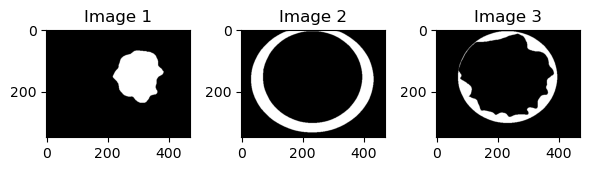

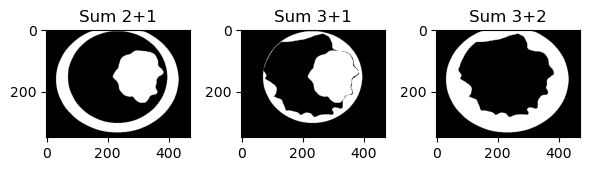

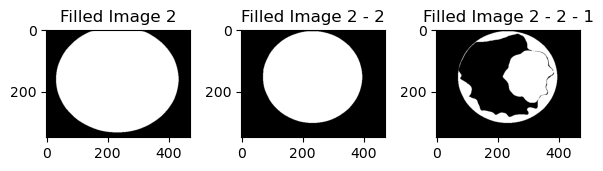

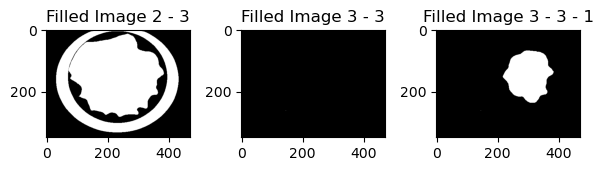

In [13]:
plot_images(initial_labels, titles)
plot_images(sum_labels, sum_titles)
plot_images(filled_labels_2, filled_titles_2)
plot_images(filled_labels_3, filled_titles_3)

## Plot sample image masked

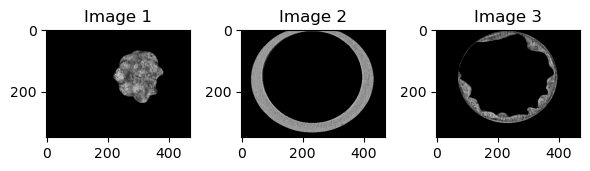

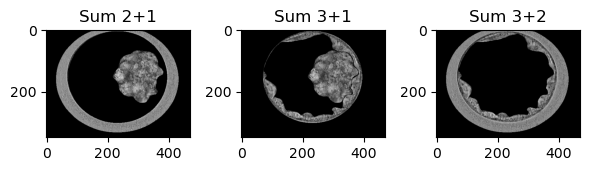

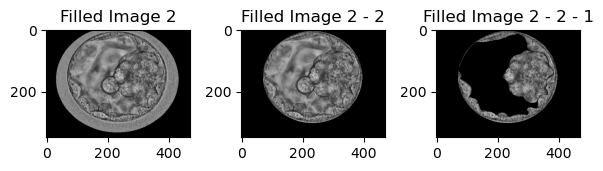

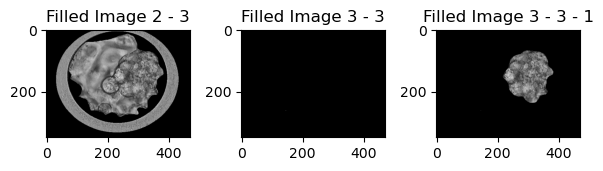

In [14]:
masked_images = segmentate_images(img_Blast, initial_labels)
masked_sum_images = segmentate_images(img_Blast, sum_labels)
masked_filled_images_2 = segmentate_images(img_Blast, filled_labels_2)
masked_filled_images_3 = segmentate_images(img_Blast, filled_labels_3)


plot_images(masked_images, titles)
plot_images(masked_sum_images, sum_titles)
plot_images(masked_filled_images_2, filled_titles_2)
plot_images(masked_filled_images_3, filled_titles_3)

## Plot sample labels cropped

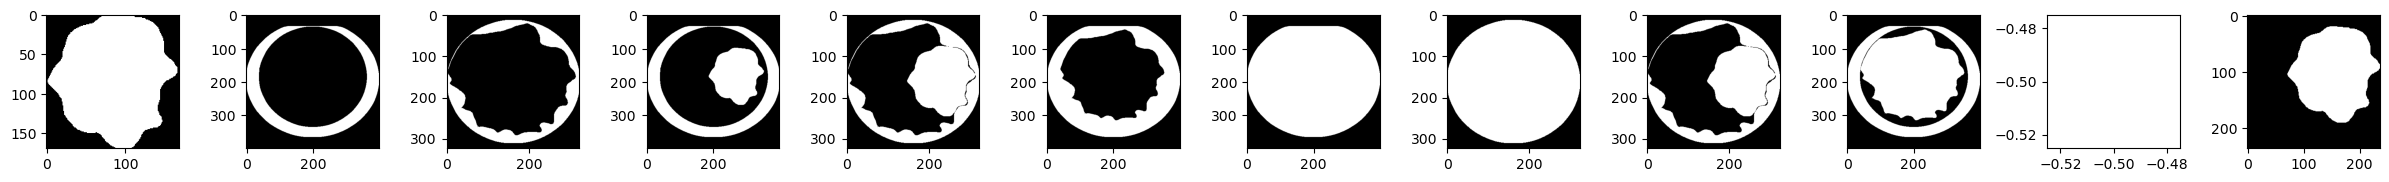

In [15]:
cropped_labels = []

all_labels = initial_labels + sum_labels + filled_labels_2 + filled_labels_3

for labels in all_labels:
    cropped_label = crop_binary_image(labels)
    cropped_labels.append(cropped_label)

plot_images(cropped_labels)

# 4) Fine Tunning

# 4) Feature extraction

Visualization and feature extraction arguments

In [16]:
n_data = 250

min_distance = 10
threshold = 0.005
height = 0
window_length=10
polyorder=2
arguments_TE = [window_length, polyorder, min_distance ,threshold, height]
arguments_ZP = arguments_TE.copy()

min_distance = 10
threshold = 0.02
height = 0
window_length=10
polyorder=2
arguments_ICM = [window_length, polyorder, min_distance ,threshold, height]

arguments_zones = [arguments_TE, arguments_ZP, arguments_ICM]

vis_polar = False
vis_cells = False
vis_cell_divisions = False
vis_arguments = [vis_polar, vis_cells, vis_cell_divisions]

Feature extraction process

In [17]:
#|features = feature_extraction_full_dataset(arguments_zones, vis_arguments)

In [18]:
with open('data/segmented_features/features.json', 'r') as archivo:
    features = json.load(archivo)

# 5) Load labels

In [19]:
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,251):
    blast_quality.append(list(sheet['B'+str(i)].value))

In [20]:
def choose_region(zone):
  X_data = np.zeros((n_data-1, len(features[0])))
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)

  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert(blast_quality[i-1][1])
    y_TE[i-1] = convert(blast_quality[i-1][2])
    y_ZP[i-1] = convert(blast_quality[i-1][0])
    X_data[i-1] = features[i-1]

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return X_data, y_data

X,y = choose_region('ICM')

In [21]:
# Sanity check:

print(len(X) == n_data-1)

print(len(y) == n_data-1)

True
True


# 6) Entrenamiento

## Principal component analysis

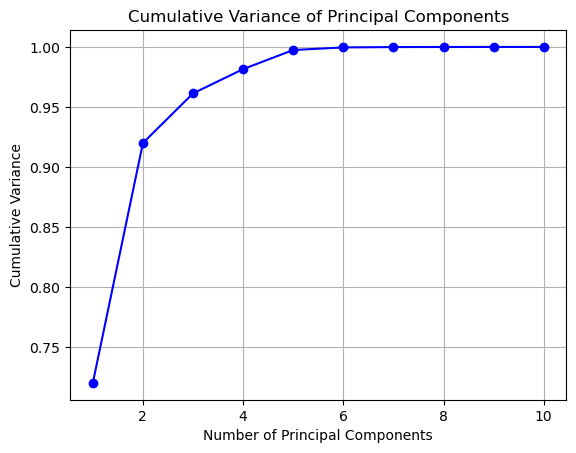

In [22]:
X_pca = apply_PCA(X, 10)

## Decision Tree

In [23]:
# Definir un espacio de búsqueda más amplio para la búsqueda de cuadrícula

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced']
}

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}


clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Mean Accuracy in cross-validation: 0.46833782679738556
Standard Deviation of Accuracy in cross-validation: 0.0843670114974066


0it [00:00, ?it/s]

Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Mean Accuracy in cross-validation: 0.5632475490196078
Standard Deviation of Accuracy in cross-validation: 0.09515641196035292


## Random Forest

In [24]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.8, 0.9, 1.0],  # Solo para bootstrap=True
    'oob_score': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Mean Accuracy in cross-validation: 0.6646582244008714
Standard Deviation of Accuracy in cross-validation: 0.03646229755761875


0it [00:00, ?it/s]

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Mean Accuracy in cross-validation: 0.6599455337690632
Standard Deviation of Accuracy in cross-validation: 0.05890538764927195


## SVM

In [25]:
clf = SVC(class_weight='balanced', random_state=42)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1e-3, 1e-4],
    'degree': [2, 3, 4],  # Solo para kernel 'poly'
    'coef0': [0.0, 0.1, 1.0]  # Solo para kernel 'poly' y 'sigmoid'
}

# Definir el espacio de búsqueda
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Mean Accuracy in cross-validation: 0.5498937908496733
Standard Deviation of Accuracy in cross-validation: 0.07292395196208197


0it [00:00, ?it/s]

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Mean Accuracy in cross-validation: 0.5564542483660131
Standard Deviation of Accuracy in cross-validation: 0.08661129397343283


## Naive bayes

In [26]:
# Crear el clasificador Naive Bayes
clf = GaussianNB()

# Definir el espacio de búsqueda
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'var_smoothing': 1.0}

Mean Accuracy in cross-validation: 0.5485807656395891
Standard Deviation of Accuracy in cross-validation: 0.048107406828697484


0it [00:00, ?it/s]

Best parameters: {'var_smoothing': 0.1}

Mean Accuracy in cross-validation: 0.6443697478991596
Standard Deviation of Accuracy in cross-validation: 0.05381299006215808


## Perceptrón

In [27]:
# Crear el clasificador Perceptrón Multicapa (MLP)
clf = MLPClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'tol': [1e-4, 1e-3, 1e-2],
    'momentum': [0.9, 0.8, 0.7],
    'beta_1': [0.9, 0.8, 0.7],
    'beta_2': [0.999, 0.9, 0.8],
}

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'max_iter': 200}

Mean Accuracy in cross-validation: 0.6206490872210952
Standard Deviation of Accuracy in cross-validation: 0.1397579735507353


0it [00:00, ?it/s]

Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.1, 'max_iter': 100}

Mean Accuracy in cross-validation: 0.6721470637230404
Standard Deviation of Accuracy in cross-validation: 0.07640873780074812


## XGBoost

In [28]:
# Crear el clasificador XGBoost
clf = xgb.XGBClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10],
}
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

Mean Accuracy in cross-validation: 0.6753792463487454
Standard Deviation of Accuracy in cross-validation: 0.02868525926654188


0it [00:00, ?it/s]

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Mean Accuracy in cross-validation: 0.5540123456790124
Standard Deviation of Accuracy in cross-validation: 0.06495772951511002


In [29]:
len(features[0])

143

In [30]:
'''
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']
def features_principales(best_model):
    
    feats_princ = []
    orden = np.flip(np.argsort(best_model.feature_importances_))
    #print(np.flip(np.sort(best_model.feature_importances_)))
    print(len(nombres))
    for i in range(len(orden)):
        feats_princ.append(nombres[orden[i]])
    return feats_princ

def features_values(best_model, names):
  vals = np.flip(np.sort(bestimator.feature_importances_))
  plt.figure(figsize=(10,5))
  ticks = np.arange(len(vals))
  labels = names
  plt.xticks(ticks, labels, rotation = 90)
  plt.bar(np.arange(len(vals)),vals)
'''

"\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']\ndef features_principales(best_model):\n    \n    feats_princ = []\n    orden = np.flip(np.argsort(best_model.feature_importances_))\n    #print(np.flip(np.sort(best_model.feature_importances_)))\n    print(len(nombres))\n    for i in range(len(orden)):\n        feats_princ.append(nombres[orden[i]])\n    return feats_princ\n\ndef features_values(best_model, names):\n  vals = np.fl